In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Flatten, Embedding

import numpy as np
import matplotlib.pyplot as plt


2023-07-08 14:08:30.641171: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-08 14:08:30.681720: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-08 14:08:31.388863: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


We will now look at how to generate `word-embeddings` using a binary sentiment classification task. We will user the IMDB movie reviews data set.

In [2]:
import tensorflow_datasets as tfds

/home/tanzid/miniconda3/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

# load the IMDB movie reviews dataset
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)


In [4]:
print(info)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_path='/home/tanzid/tensorflow_datasets/imdb_reviews/plain_text/1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=25000, num_shards=

In [5]:
# note that the imdb dataset dictionary contains 3 splits: train, test and unsupervised (i.e. unlabeled)
print(imdb)

{'train': <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, 'test': <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, 'unsupervised': <_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}


In [6]:
# let's look at the contents of two training examples
for example in imdb['train'].take(3):
    print()
    print(example)
    # each eaxample is a tuple of two values, a review string and a sentiment integer which is 1 (positive) or 0 (negative)
    print(f"Review: {example[0]}")
    print(f"Sentiment: {example[1]}\n")


(<tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.">, <tf.Tensor: shape=(), dtype=int64, numpy=0>)
Review: b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their

2023-07-08 14:08:43.865172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [1]
	 [[{{node Placeholder/_1}}]]
2023-07-08 14:08:43.866145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2023-07-08 14:08:43.946580: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline s

In [7]:
# store the train and test data into separate lists for review sentences and labels
train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []
test_sentences = []
test_labels = []

for review,label in train_data:
    # need to convert tensorflow tensor object to numpy array element
    training_sentences.append(review.numpy().decode('utf8'))
    training_labels.append(label.numpy())

for review,label in test_data:
    # need to convert tensorflow tensor object to numpy array element
    test_sentences.append(review.numpy().decode('utf8'))
    test_labels.append(label.numpy())

# convert labels to numpy arrays
training_labels_final = np.array(training_labels)
test_labels_final = np.array(test_labels)

2023-07-08 14:08:48.240229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{node Placeholder/_3}}]]
2023-07-08 14:08:48.240744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-07-08 14:08:53.362280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [1]
	 [[{{nod

Now use the Tokenizer to generate vocabulary and then create padded sequences

In [8]:
# parameters
vocab_size = 10000   
max_length = 120     # uniform sequence length
embedding_dim = 16   # dimensions of embedding vectors
trunc_type = 'post'
oov_tok = "<OOV>"

In [9]:
# instantiate tokenizer object
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# generate vocabulary using training dataset
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
index_word = tokenizer.index_word

# create padded sequences for training data
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, truncating=trunc_type)

# create padded sequences for test data
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length, truncating=trunc_type)

Now that all the preprocessing is done, build a fully connected neural network model for sentiment classification. The first layer will be an embedding layer. The parameters of the embedding layer is the embedding matrix of shape (vocab_length, embedding_dim), each row of this matrix is an embedding vector representation for the corresponding word from the vocabulary 

In [10]:
# build the model
model = keras.models.Sequential([Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
                                 Flatten(),
                                 Dense(units=6, activation='relu'),
                                 Dense(units=1, activation='sigmoid')])

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 6)                 11526     
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


Now, we will train the model on the imdb dataset and then look at the learned embedding matrix

In [11]:
num_epochs = 6

In [12]:
# train the model
model.fit(training_padded, training_labels_final, validation_data=(test_padded, test_labels_final), epochs=num_epochs)

Epoch 1/6
782/782 [==============================] - 6s 6ms/step - loss: 0.4927 - accuracy: 0.7409 - val_loss: 0.3857 - val_accuracy: 0.8268
Epoch 2/6
782/782 [==============================] - 5s 6ms/step - loss: 0.2438 - accuracy: 0.9060 - val_loss: 0.4048 - val_accuracy: 0.8254
Epoch 3/6
782/782 [==============================] - 6s 8ms/step - loss: 0.1039 - accuracy: 0.9706 - val_loss: 0.4960 - val_accuracy: 0.8120
Epoch 4/6
782/782 [==============================] - 6s 7ms/step - loss: 0.0255 - accuracy: 0.9967 - val_loss: 0.5936 - val_accuracy: 0.8104
Epoch 5/6
782/782 [==============================] - 5s 7ms/step - loss: 0.0063 - accuracy: 0.9995 - val_loss: 0.6781 - val_accuracy: 0.8112
Epoch 6/6
782/782 [==============================] - 4s 6ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.7410 - val_accuracy: 0.8098


In [14]:
# now get the embedding layer weights
embedding_matrix = model.layers[0].get_weights()[0]

print(embedding_matrix.shape)

(10000, 16)


Save the word embedding vectors along with the words in tsv files to visualize in Tensorflow Embedding Projector

In [13]:
import io

# open files
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# loop over all word indices
for idx in range(1, vocab_size):
    # get the word for this index number
    word = index_word[idx]
    # get the embedding vector for this word
    vec = embedding_matrix[idx]
    # write to file (each line contains tab separated values)
    out_m.write(word + "\n")
    out_v.write("\t".join([str(x) for x in vec])+ "\n")

# close the files
out_v.close()
out_m.close()


Now let's train a binary classifier on the `Sarcasm`` dataset, which contains 25000 training and 3=25000 test examples.

In [13]:
import json

# load the sarcasm dataset from file
with open("./sarcasm.json", 'r') as f:
    datastore = json.load(f)


# get the sentences and labels
sentences = []
labels = []
for item in datastore:
    sentences.append(item['headline'])    
    labels.append(item['is_sarcastic'])    

In [115]:
# some hyperparameters
training_size = 20000 # number of examples to use for training
vocab_size = 5000 
max_length = 32    # length of padded sequences (much smaller than what we used for the imdb dataset, since news headline sentences are shorter)
embedding_dim = 16 # dimensions of embedding vectors

trunc_type = 'post'
pad_type = 'post'
oov_tok = "<OOV>"

In [112]:
# split the data
training_sentences = sentences[:training_size]
training_labels = labels[:training_size]
test_sentences = sentences[training_size:]
test_labels = labels[training_size:]

# preprocess to get vocabulary and padded sequences
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

training_padded = pad_sequences(training_sequences, maxlen = max_length, padding=pad_type, truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen = max_length, padding=pad_type, truncating=trunc_type)

# convert labels to numpy arrays
training_labels = np.array(training_labels) 
test_labels = np.array(test_labels) 

In [113]:
from keras.layers import GlobalAveragePooling1D

# build the model, this time we use a global average pooling instead of a flatten layer after the embedding layer. This will compute the average embedding vector from the embedding vectors of all the words in an input sequence (i.e. averaging over the second to last input dimension)
model = keras.models.Sequential([Embedding(vocab_size, embedding_dim, input_length=max_length),
                                 GlobalAveragePooling1D(),
                                 Dense(units=4, activation='relu'),
                                 Dense(units=1, activation='sigmoid')])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 32, 16)            80000     
                                                                 


 global_average_pooling1d_22  (None, 16)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_47 (Dense)            (None, 4)                 68        
                                                                 
 dense_48 (Dense)            (None, 1)                 5         
                                                                 
Total params: 80,073
Trainable params: 80,073
Non-trainable params: 0
_________________________________________________________________


In [114]:
# now train the model
num_epochs = 8

history = model.fit(training_padded, training_labels, validation_data=(test_padded, test_labels), epochs=num_epochs, verbose=2)

Epoch 1/8


657/657 - 3s - loss: 0.6338 - accuracy: 0.6825 - val_loss: 0.5212 - val_accuracy: 0.7891 - 3s/epoch - 4ms/step
Epoch 2/8
657/657 - 2s - loss: 0.4160 - accuracy: 0.8407 - val_loss: 0.3877 - val_accuracy: 0.8362 - 2s/epoch - 3ms/step
Epoch 3/8
657/657 - 2s - loss: 0.3213 - accuracy: 0.8719 - val_loss: 0.3542 - val_accuracy: 0.8499 - 2s/epoch - 3ms/step
Epoch 4/8
657/657 - 2s - loss: 0.2801 - accuracy: 0.8870 - val_loss: 0.3481 - val_accuracy: 0.8499 - 2s/epoch - 3ms/step
Epoch 5/8
657/657 - 2s - loss: 0.2547 - accuracy: 0.8967 - val_loss: 0.3505 - val_accuracy: 0.8474 - 2s/epoch - 3ms/step
Epoch 6/8
657/657 - 2s - loss: 0.2361 - accuracy: 0.9059 - val_loss: 0.3578 - val_accuracy: 0.8457 - 2s/epoch - 3ms/step
Epoch 7/8
657/657 - 2s - loss: 0.2219 - accuracy: 0.9107 - val_loss: 0.3675 - val_accuracy: 0.8453 - 2s/epoch - 3ms/step
Epoch 8/8
657/657 - 2s - loss: 0.2109 - accuracy: 0.9153 - val_loss: 0.3783 - val_accuracy: 0.8431 - 2s/epoch - 2ms/step


In [110]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_"+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_"+metric])
    plt.show()

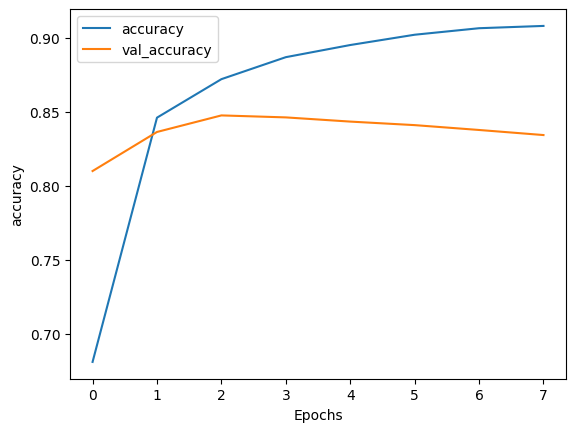

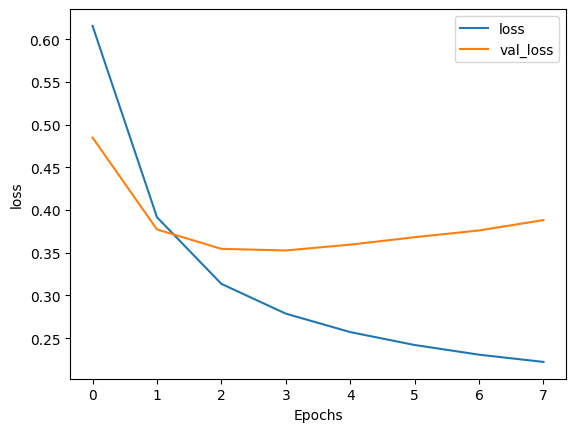

In [105]:
# lets now plot some learning curves
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")
